In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input, regularizers

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train_flat = x_train.reshape(-1, 784)
x_test_flat  = x_test.reshape(-1, 784)

def add_noise(x, noise_factor=0.35):
    noisy = x + noise_factor * tf.random.normal(shape=tf.shape(x))
    return tf.clip_by_value(noisy, 0.0, 1.0)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

def build_sparse_ae(input_dim=784, l1_strength=1e-6):
    inp = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(256, activation="relu")(inp)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    code = tf.keras.layers.Dense(
        64, activation="relu",
        activity_regularizer=tf.keras.regularizers.l1(l1_strength)
    )(x)

    x = tf.keras.layers.Dense(128, activation="relu")(code)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    out = tf.keras.layers.Dense(input_dim, activation="sigmoid")(x)

    model = tf.keras.Model(inp, out, name="SparseAE_fixed")
    model.compile(optimizer="adam", loss="mse")
    return model

def build_denoising_ae(input_dim=784):
    inp = Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dense(128, activation="relu")(x)
    code = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(code)
    x = layers.Dense(256, activation="relu")(x)
    out = layers.Dense(input_dim, activation="sigmoid")(x)
    model = Model(inp, out, name="DenoisingAE")
    model.compile(optimizer="adam", loss="mse")
    return model

sparse_ae = build_sparse_ae(l1_strength=1e-5)
denoise_ae = build_denoising_ae()

EPOCHS = 20
BATCH = 256

print("\nTraining Sparse Autoencoder...")
hist_sparse = sparse_ae.fit(
    x_train_flat, x_train_flat,
    epochs=EPOCHS, batch_size=BATCH,
    validation_data=(x_test_flat, x_test_flat),
    verbose=1
)

print("\nTraining Denoising Autoencoder...")
x_train_noisy = add_noise(x_train_flat, noise_factor=0.35)
x_test_noisy  = add_noise(x_test_flat,  noise_factor=0.35)

hist_denoise = denoise_ae.fit(
    x_train_noisy, x_train_flat,
    epochs=EPOCHS, batch_size=BATCH,
    validation_data=(x_test_noisy, x_test_flat),
    verbose=1
)



Training Sparse Autoencoder...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1112 - val_loss: 0.0480
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0452 - val_loss: 0.0386
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0374 - val_loss: 0.0329
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0313 - val_loss: 0.0281
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0274 - val_loss: 0.0261
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257 - val_loss: 0.0250
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0240 - val_loss: 0.0236
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0234 - val_loss: 0.0230
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0229 - val_loss: 0.0227
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0224 - val_loss: 0.0221
Epoch 12/20
235/235


=== Final Validation Loss (MSE) ===
Sparse AE   : 0.019409
Denoising AE: 0.014058


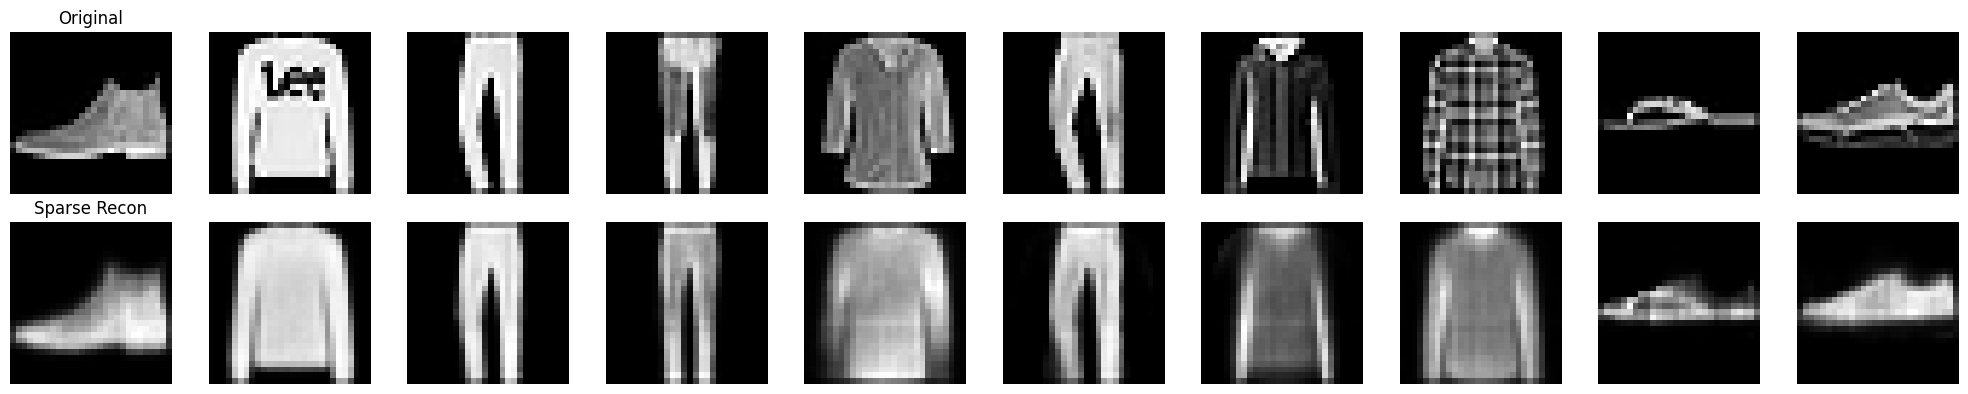

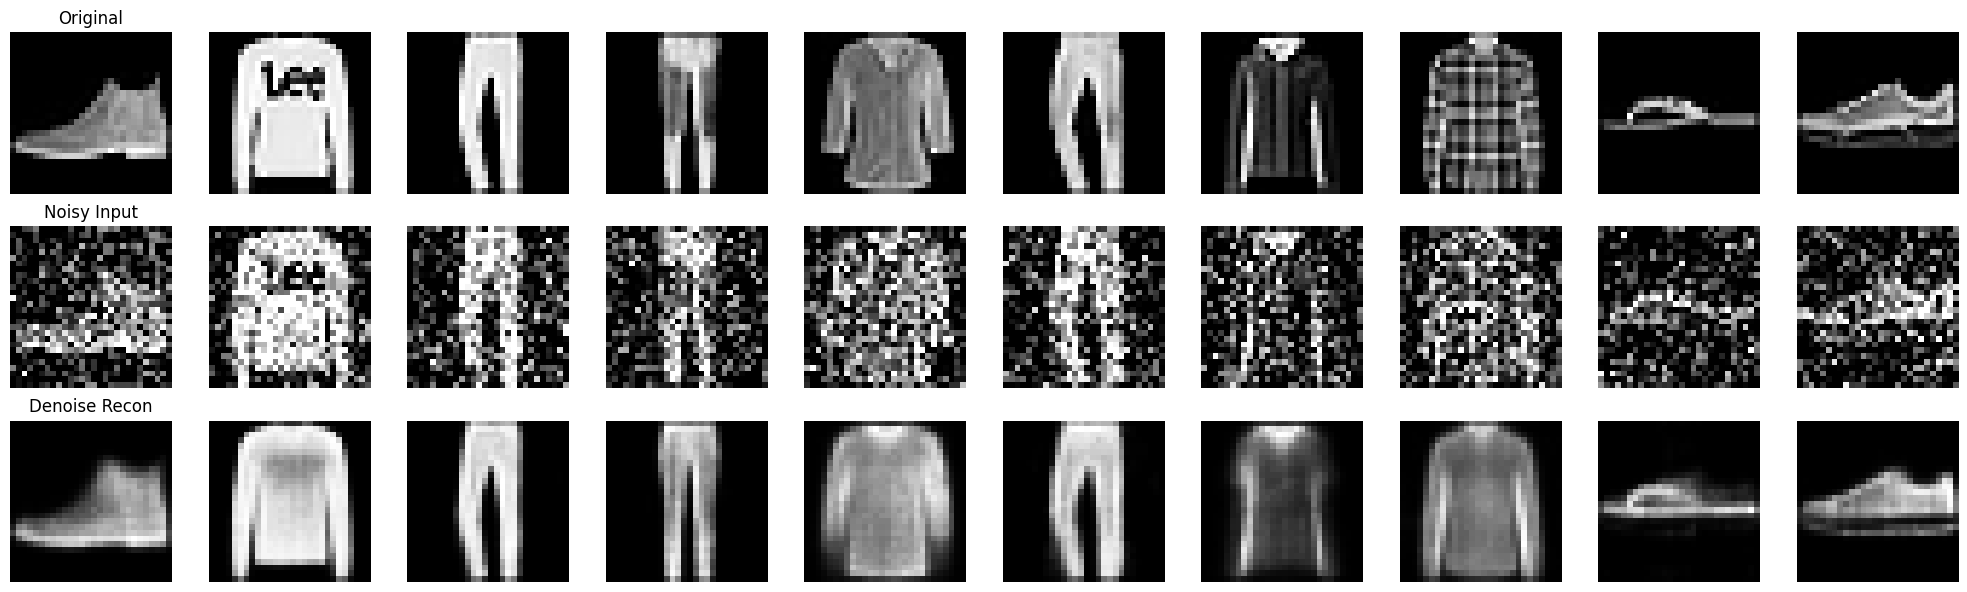

In [ ]:

sparse_val_loss = hist_sparse.history["val_loss"][-1]
denoise_val_loss = hist_denoise.history["val_loss"][-1]

print("\n=== Final Validation Loss (MSE) ===")
print(f"Sparse AE   : {sparse_val_loss:.6f}")
print(f"Denoising AE: {denoise_val_loss:.6f}")

def plot_sparse_results(model, x_test_flat, n=10):
    preds = model.predict(x_test_flat[:n], verbose=0)
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_flat[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Original")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(preds[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Sparse Recon")
    plt.tight_layout()
    plt.show()

def plot_denoise_results(model, x_test_flat, noise_factor=0.35, n=10):
    noisy = add_noise(x_test_flat[:n], noise_factor=noise_factor)
    preds = model.predict(noisy, verbose=0)
    noisy_np = noisy.numpy()

    plt.figure(figsize=(2*n, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_flat[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Original")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_np[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Noisy Input")

        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(preds[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0: ax.set_title("Denoise Recon")
    plt.tight_layout()
    plt.show()

plot_sparse_results(sparse_ae, x_test_flat, n=10)
plot_denoise_results(denoise_ae, x_test_flat, noise_factor=0.35, n=10)
